In [ ]:
# LSTM - WindMills
'''Точечное прогнозирование. В данном случае модель обучается прогнозированию одного значения в будущем 
на основе имеющейся истории по одной переменной.'''

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing the dataset
wma = pd.read_csv('WindMillsActual.csv')

In [4]:
wma

,Time,Wind_direction,Temperature,Pressure,Humidity
0,1/1/2016 0:00,101.0,1.3,885.9,65.4
1,1/1/2016 0:15,98.1,1.3,885.7,67.2
2,1/1/2016 0:30,99.8,1.2,885.6,68.1
3,1/1/2016 0:45,102.4,1.2,885.5,68.8
4,1/1/2016 1:00,102.8,1.2,885.3,70.1
...,...,...,...,...,...
70172,12/31/2017 23:00,63.4,2.1,885.5,45.2
70173,12/31/2017 23:15,75.9,2.0,885.3,45.5
70174,12/31/2017 23:30,69.4,2.1,885.3,45.8
70175,12/31/2017 23:45,72.9,2.0,885.2,46.2


In [3]:
# Checking missing
total = wma.isnull().sum().sort_values(ascending=False)
percent = (wma.isnull().sum()/wma.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Wind_direction,33067,0.471194
Humidity,33050,0.470952
Pressure,33007,0.470339
Temperature,33004,0.470297
Time,0,0.000000


In [4]:
wma = wma.dropna()

In [5]:
wma.describe()

,Wind_direction,Temperature,Pressure,Humidity
count,37070.000000,37070.000000,37070.000000,37070.000000
mean,198.969852,8.703280,893.071573,66.159884
std,101.235127,8.949399,13.317089,27.550012
min,0.500000,-16.000000,868.100000,0.200000
25%,97.000000,1.300000,883.800000,42.800000
50%,262.000000,7.900000,886.700000,66.000000
75%,296.400000,16.400000,903.200000,99.100000
max,359.900000,27.200000,945.500000,99.400000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020574267948>],
      dtype=object)

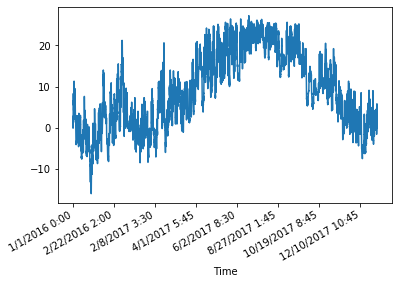

In [6]:
'''Извлечем только температуру из набора данных.'''
# Features 
uni_data = wma['Temperature']
uni_data.index = wma['Time']
uni_data.plot(subplots=True)

In [7]:
'''Функция возвращает временные интервалы для обучения модели. 
Аргумент history_size — размер временного интервала, на основе которого будет делаться прогноз, 
target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. 
Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.'''
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [8]:
'''Подготовим данные для модели с одномерным входом.'''
uni_data = uni_data.values

'''Первые 30 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). 
В этом случае объём обучающих данных составляет примерно 313 дней.'''
# Splitting dataset
TRAIN_SPLIT = 30000
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

'''Стандартизация должна выполняться только c использованием обучающих данных.'''
# Feature Scaling
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [9]:
uni_data

array([-0.89140509, -0.89140509, -0.90210683, ..., -0.80579123,
       -0.81649297, -0.80579123])

In [10]:
'''На вход в модель будут подаваться последние 12 зарегистрированных наблюдений за температурой, 
модель необходимо обучить прогнозировать температуру на следующем шаге по времени.'''
# Creating lagged dataset
univariate_past_history = 12
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [14]:
'''Результаты применения функции univariate_data.'''
# Sliding window
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.89140509]
 [-0.89140509]
 [-0.90210683]
 [-0.90210683]
 [-0.90210683]
 [-0.91280856]
 [-0.92351029]
 [-0.92351029]
 [-0.93421202]
 [-0.93421202]
 [-0.93421202]
 [-0.93421202]]

 Target temperature to predict
-0.9342120241965741


In [9]:
def create_time_steps(length):
  return list(range(-length, 0))

In [10]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\kater\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

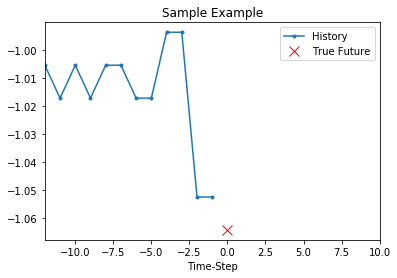

In [11]:
# One sliding window plotting
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [12]:
'''Прежде чем приступить к обучению модели, рассчитаем базовое решение (baseline). 
Оно заключается в следующем: для заданного входного вектора метод базового решения 
«просматривает» всю историю и прогнозирует следующее значение как среднее из последних 12 наблюдений.'''
# Baseline model
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\kater\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

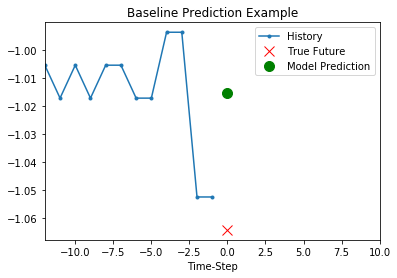

In [13]:
# Baseline Prediction plotting
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [20]:
# Importing the Tensorflow libraries and packages
import tensorflow as tf
#from tf.data import Dataset

# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [21]:
'''C помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.'''
# Data preprocessing
BATCH_SIZE = 128
BUFFER_SIZE = 500

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [22]:
# LSTM creating
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [30]:
'''Проверим выход модели'''
simple_lstm_model.predict(val_univariate.take(1)).shape

(128, 1)

In [32]:
'''В общем плане РНС работают с последовательностями (sequences). 
Это означает, что подаваемые на вход модели данные должны иметь следующую форму:
[наблюдения, временной интервал, кол-во признаков]
Форма обучающих данных для модели с одномерным входом имеет следующий вид:'''
print(x_train_uni.shape)

(29988, 12, 1)


In [33]:
# Fitting
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
200/200 [==============================] - 5s 25ms/step - loss: 0.5911 - val_loss: 0.8782
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.2820 - val_loss: 0.5716
Epoch 3/10
200/200 [==============================] - 3s 15ms/step - loss: 0.1522 - val_loss: 0.3135
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0901 - val_loss: 0.1402
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0681 - val_loss: 0.0988
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0570 - val_loss: 0.0901
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0482 - val_loss: 0.0807
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0453 - val_loss: 0.0741
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0433 - val_loss: 0.06

<module 'matplotlib.pyplot' from 'C:\\Users\\kater\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

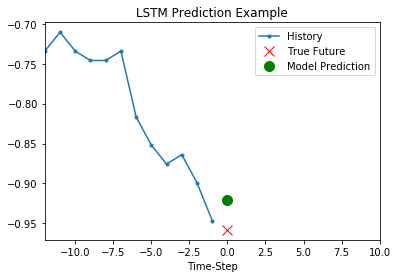

In [51]:
# LSTM Prediction plotting
show_plot([x_val_uni[0], y_val_uni[0], simple_lstm_model.predict(val_univariate.take(1))[0]], 0,
           'LSTM Prediction Example')

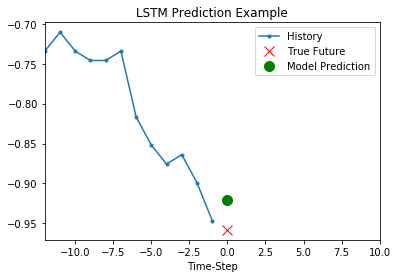

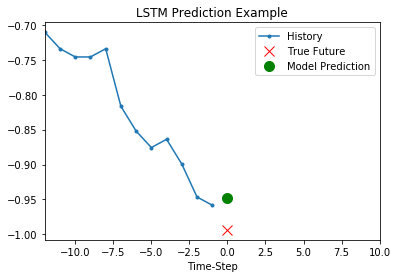

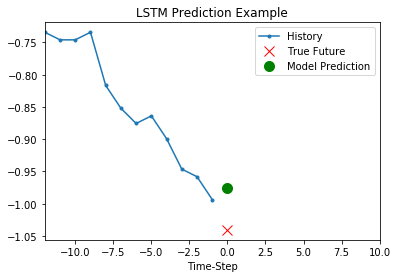

In [57]:
# LSTM Prediction plotting
for i in range(0,3):
    plot = show_plot([x_val_uni[i], y_val_uni[i], simple_lstm_model.predict(val_univariate.take(1))[i]], 0,
           'LSTM Prediction Example')
    plot.show()